In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.preprocessing import image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import image
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image

# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [2]:
train_categories = pd.read_csv('train.csv')
emergency = train_categories.loc[(train_categories['emergency_or_not'] == 1), 'image_names'].values.tolist()
not_emergency = train_categories.loc[(train_categories['emergency_or_not'] == 0), 'image_names'].values.tolist()
location = 'C:\\Users\\ak19919\\Downloads\\Github\\Analytics-Vidya\\janata-hack_computer_vision_hackathon\\images'
train_images = train_categories.image_names.values.tolist()
test_images = pd.read_csv('test.csv')
testImages = test_images.image_names.values.tolist()

In [3]:
def create_train_data():
    if not os.path.exists(location + str('\\train_images')):
        os.makedirs(location + str('\\train_images\\emergency'))
        os.makedirs(location + str('\\train_images\\not_emergency'))
        for image in emergency:
            shutil.move(location + '\\' + str(image), location + str('\\train_images\\emergency'))
        os.makedirs(location + str('\\train_images\\not_emergency'))
        for image in not_emergency:
            shutil.move(location + '\\' + str(image), location + str('\\train_images\\not_emergency'))
    if not os.path.exists(location + str('\\test_images')):
        os.makedirs(location + str('\\test_images'))
        for image in testImages:
            shutil.move(location + '\\' + str(image), location + str('\\test_images'))
    else: return

In [4]:
create_train_data()

In [5]:
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Make all the layers non trainable

In [6]:
for layer in pre_trained_model.layers:
    layer.trainable = False

Define a Callback class that stops training once accuracy reaches 95%

In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.959):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [8]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.4,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(location + '\\train_images',
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(location + '\\validation_images',
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (224, 224))

Found 1317 images belonging to 2 classes.
Found 329 images belonging to 2 classes.


In [10]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 1,
            callbacks=[callbacks])

Epoch 1/100
100/100 [==============================] - 549s 5s/step - loss: 1.1944 - acc: 0.7071 - val_loss: 0.4639 - val_acc: 0.8558
Epoch 2/100
100/100 [==============================] - 455s 5s/step - loss: 0.5400 - acc: 0.7723 - val_loss: 0.4089 - val_acc: 0.8722
Epoch 3/100
100/100 [==============================] - 419s 4s/step - loss: 0.4606 - acc: 0.8104 - val_loss: 0.4179 - val_acc: 0.8589
Epoch 4/100
100/100 [==============================] - 419s 4s/step - loss: 0.4311 - acc: 0.8247 - val_loss: 0.4217 - val_acc: 0.8804
Epoch 5/100
100/100 [==============================] - 419s 4s/step - loss: 0.3915 - acc: 0.8277 - val_loss: 1.0158 - val_acc: 0.7699
Epoch 6/100
100/100 [==============================] - 426s 4s/step - loss: 0.3872 - acc: 0.8475 - val_loss: 0.4130 - val_acc: 0.8998
Epoch 7/100
100/100 [==============================] - 424s 4s/step - loss: 0.3689 - acc: 0.8435 - val_loss: 0.4730 - val_acc: 0.8906
Epoch 8/100
100/100 [==============================] - 413s 4s

Epoch 62/100
100/100 [==============================] - 416s 4s/step - loss: 0.2657 - acc: 0.9009 - val_loss: 1.2944 - val_acc: 0.8814
Epoch 63/100
100/100 [==============================] - 433s 4s/step - loss: 0.2779 - acc: 0.8983 - val_loss: 1.3050 - val_acc: 0.8773
Epoch 64/100
100/100 [==============================] - 425s 4s/step - loss: 0.2718 - acc: 0.8982 - val_loss: 1.5109 - val_acc: 0.8548
Epoch 65/100
100/100 [==============================] - 419s 4s/step - loss: 0.2470 - acc: 0.9102 - val_loss: 1.2180 - val_acc: 0.8988
Epoch 66/100
100/100 [==============================] - 533s 5s/step - loss: 0.2746 - acc: 0.9049 - val_loss: 1.0878 - val_acc: 0.8957
Epoch 67/100
100/100 [==============================] - 635s 6s/step - loss: 0.2367 - acc: 0.9127 - val_loss: 1.6797 - val_acc: 0.8589
Epoch 68/100
100/100 [==============================] - 681s 7s/step - loss: 0.2532 - acc: 0.9044 - val_loss: 1.2873 - val_acc: 0.8824
Epoch 69/100
100/100 [==============================] -

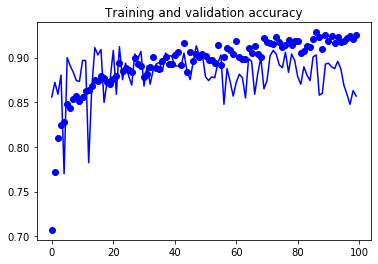

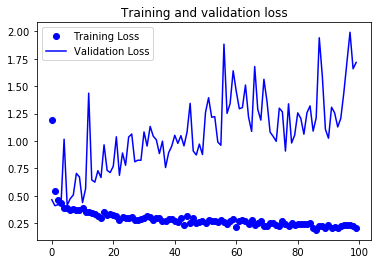

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
from keras.preprocessing import image
results = {}
for Img in testImages:
    path = location + str('\\test_images\\') + str(Img)
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size = 10)
    print(classes[0])
    if classes[0]>0.5:
        print(str(Img) + " is a non emergency vehicle")
        results.update({str(Img): 0})
    else:
        print(str(Img) + " is an emergency vehicle")
        results.update({str(Img): 1})

[0.]
1960.jpg is an emergency vehicle
[0.]
668.jpg is an emergency vehicle
[0.]
2082.jpg is an emergency vehicle
[0.]
808.jpg is an emergency vehicle
[0.]
1907.jpg is an emergency vehicle
[0.]
350.jpg is an emergency vehicle
[0.]
1557.jpg is an emergency vehicle
[0.9999999]
111.jpg is a non emergency vehicle
[0.]
1952.jpg is an emergency vehicle
[0.]
1466.jpg is an emergency vehicle
[0.]
2071.jpg is an emergency vehicle
[0.]
1891.jpg is an emergency vehicle
[0.]
1900.jpg is an emergency vehicle
[0.]
1927.jpg is an emergency vehicle
[0.]
1414.jpg is an emergency vehicle
[0.]
134.jpg is an emergency vehicle
[0.]
1037.jpg is an emergency vehicle
[0.]
56.jpg is an emergency vehicle
[0.]
208.jpg is an emergency vehicle
[0.]
629.jpg is an emergency vehicle
[0.]
979.jpg is an emergency vehicle
[0.]
2099.jpg is an emergency vehicle
[0.]
332.jpg is an emergency vehicle
[0.]
1814.jpg is an emergency vehicle
[0.]
1094.jpg is an emergency vehicle
[0.]
1886.jpg is an emergency vehicle
[0.]
342.jpg 

[0.]
251.jpg is an emergency vehicle
[0.]
1703.jpg is an emergency vehicle
[0.]
416.jpg is an emergency vehicle
[0.]
1357.jpg is an emergency vehicle
[0.]
1645.jpg is an emergency vehicle
[0.]
1163.jpg is an emergency vehicle
[0.]
1263.jpg is an emergency vehicle
[0.]
618.jpg is an emergency vehicle
[0.]
450.jpg is an emergency vehicle
[0.]
1264.jpg is an emergency vehicle
[0.]
1320.jpg is an emergency vehicle
[0.]
859.jpg is an emergency vehicle
[0.]
291.jpg is an emergency vehicle
[0.]
1798.jpg is an emergency vehicle
[0.]
2311.jpg is an emergency vehicle
[1.]
1223.jpg is a non emergency vehicle
[1.]
998.jpg is a non emergency vehicle
[0.]
2181.jpg is an emergency vehicle
[0.]
817.jpg is an emergency vehicle
[0.]
296.jpg is an emergency vehicle
[0.]
1364.jpg is an emergency vehicle
[0.]
410.jpg is an emergency vehicle
[0.]
1004.jpg is an emergency vehicle
[0.]
528.jpg is an emergency vehicle
[0.]
1303.jpg is an emergency vehicle
[0.]
1382.jpg is an emergency vehicle
[0.]
637.jpg is a

[0.]
787.jpg is an emergency vehicle
[3.4935855e-08]
1344.jpg is an emergency vehicle
[0.]
599.jpg is an emergency vehicle
[0.]
286.jpg is an emergency vehicle
[0.]
2194.jpg is an emergency vehicle
[0.]
406.jpg is an emergency vehicle
[0.]
1487.jpg is an emergency vehicle
[0.]
163.jpg is an emergency vehicle
[1.]
1609.jpg is a non emergency vehicle
[1.]
423.jpg is a non emergency vehicle
[0.]
2261.jpg is an emergency vehicle
[0.]
1128.jpg is an emergency vehicle
[0.]
632.jpg is an emergency vehicle
[0.]
1883.jpg is an emergency vehicle
[0.]
1430.jpg is an emergency vehicle
[0.]
1651.jpg is an emergency vehicle
[0.]
2267.jpg is an emergency vehicle
[0.]
1269.jpg is an emergency vehicle
[0.]
700.jpg is an emergency vehicle
[0.]
457.jpg is an emergency vehicle
[0.]
650.jpg is an emergency vehicle
[0.]
900.jpg is an emergency vehicle
[0.]
230.jpg is an emergency vehicle
[0.]
1962.jpg is an emergency vehicle
[0.]
1084.jpg is an emergency vehicle
[0.]
1318.jpg is an emergency vehicle
[0.]
17

[0.]
1281.jpg is an emergency vehicle
[0.]
270.jpg is an emergency vehicle
[0.]
889.jpg is an emergency vehicle
[0.]
965.jpg is an emergency vehicle
[0.]
1772.jpg is an emergency vehicle
[1.1444537e-06]
888.jpg is an emergency vehicle
[0.]
1110.jpg is an emergency vehicle
[0.]
1848.jpg is an emergency vehicle
[0.]
429.jpg is an emergency vehicle
[0.]
1894.jpg is an emergency vehicle
[0.]
963.jpg is an emergency vehicle
[0.]
2039.jpg is an emergency vehicle
[0.]
458.jpg is an emergency vehicle
[0.]
78.jpg is an emergency vehicle
[0.]
2091.jpg is an emergency vehicle
[0.]
32.jpg is an emergency vehicle
[0.]
916.jpg is an emergency vehicle
[0.]
1644.jpg is an emergency vehicle
[0.99933416]
2113.jpg is a non emergency vehicle
[0.]
380.jpg is an emergency vehicle
[0.]
226.jpg is an emergency vehicle
[0.]
1208.jpg is an emergency vehicle
[0.]
1321.jpg is an emergency vehicle
[0.]
305.jpg is an emergency vehicle
[0.]
209.jpg is an emergency vehicle
[0.]
1143.jpg is an emergency vehicle
[0.]
1

In [21]:
Results = pd.DataFrame(results.items(), columns = ['image_names', 'emergency_or_not'])

In [22]:
final_submission = pd.merge(test_images, Results, on = ['image_names'])
final_submission.to_csv('submission_3.csv', index = False)